This script directly works on the new battery dataset (`3_clear`), the one with no ghosting effects. Here we load, save, preprocess it a little bit, and do some analysis. Then, we wrap it into dictionary and save it as a pickle file. Pickle files are nice because our SaxNerf library digests them really well. In fact, all you need to have is a well configured pickle file, and an ad-hoc configuration file inside the SaxNerf library. I'll definitely work in the morning because I'm a living dead or something. And that coffee was weird, I don't know.

Install libraries

In [ ]:
! pip install pillow imageio tifffile numpy matplotlib

Inspecting tif dataset

In [1]:
from PIL import Image
import os
from tqdm import tqdm

In [2]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt

tiff_path = "../data/battery/3_clear/LCO_abs.tif"

with tifffile.TiffFile(tiff_path) as tif:
    print(f"Number of pages in TIFF: {len(tif.pages)}") # Inspect the structure
    image_data = tif.asarray()                          # Read the image data as a numpy array
    

Number of pages in TIFF: 1


In [45]:
! tifffile --version  tiff.so

tifffile 2023.7.10


In [3]:
image_data.min(), image_data.max()

(-2.5599008, 1.5580326)

In [4]:
print(f"Extracted data shape: {image_data.shape}")

Extracted data shape: (1800, 2048, 2048)


Visualize one slice.

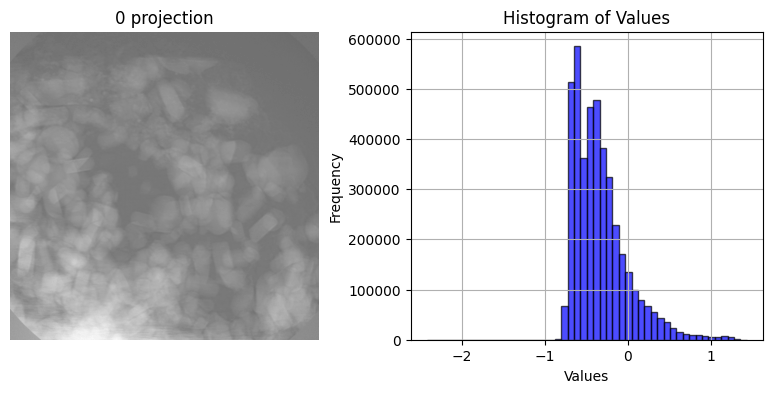

In [5]:
def show_image(image_data, id=0):
    id = id #np.random.randint(low=0, high=image_data.shape[0])
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    axes[0].imshow(image_data[id], cmap='gray')
    axes[0].set_title(f"{id} projection")
    axes[0].axis('off')

    axes[1].hist(image_data[id].flatten(), bins=50, color='blue', alpha=0.7, edgecolor='black')
    axes[1].set_title("Histogram of Values")
    axes[1].set_xlabel("Values")
    axes[1].set_ylabel("Frequency")
    axes[1].grid(True)

    plt.show()

show_image(image_data)

In [8]:
np.save('../data/battery/3_clear/projs.npy', image_data)

In [9]:
np.load('../data/battery/3_clear/projs.npy').shape

(1800, 2048, 2048)

Save to png only 180 among all the 1800 (too many and contain redundant info)

In [6]:
output_dir = "../data/battery/3_clear/png"

# Save every 10th slice
step = 10
selected_slices = range(0, len(image_data), step)  # Select every 10th slice
print(f"Saving {len(selected_slices)} slices...")

# Resize and save the selected slices
for i, slice_idx in enumerate(tqdm(selected_slices)):
    slice = image_data[slice_idx]
    
    # Normalize (0-255) and convert to uint8
    normalized_slice = ((slice - slice.min()) / (slice.max() - slice.min()) * 255).astype(np.uint8)
    
    # Resize the slice to 256x256
    resized_slice = Image.fromarray(normalized_slice).resize((256, 256), Image.BICUBIC)
    
    # Save the resized slice as a PNG file
    slice_path = os.path.join(output_dir, f"slice_{i:03d}.png")
    resized_slice.save(slice_path)

print(f"Saved {len(selected_slices)} resized slices to '{output_dir}'")

Saving 180 slices...


  0%|          | 0/180 [00:00<?, ?it/s]

100%|██████████| 180/180 [00:07<00:00, 25.42it/s]

Saved 180 resized slices to '../data/battery/3_clear/png'


Create gif

In [7]:
from PIL import Image
import os

def create_gif_from_folder(folder_path, output_filename, duration=100):
    # Get all PNG files from the folder and sort them
    images = sorted([img for img in os.listdir(folder_path) if img.endswith(".png")])
    
    # Load images into a list
    frames = [Image.open(os.path.join(folder_path, img)) for img in images]

    # Save the frames as a GIF
    frames[0].save(
        output_filename,
        save_all=True,
        append_images=frames[1:],
        duration=duration,  # Duration between frames in milliseconds
        loop=0              # Loop forever
    )

# Example usage
create_gif_from_folder("../data/battery/3_clear/png", "../data/battery/3_clear/png/anim.gif", duration=150)

Inspect raw data

In [6]:
image_data.shape

(1800, 2048, 2048)

In [7]:
def plot_statistics(projections, title):
    num_images = projections.shape[0]
    x_values = np.arange(1, num_images+1)
    min_values = []
    max_values = []
    mean_values = []

    for i in range(num_images):
        min_values.append(np.min(projections[i]))
        max_values.append(np.max(projections[i]))
        mean_values.append(np.mean(projections[i]))

    plt.figure(figsize=[8, 4])
    plt.plot(x_values, min_values, label='min')
    plt.plot(x_values, max_values, label='max')
    plt.plot(x_values, mean_values, label='mean')
    plt.title(f'max/min/mean values across {title}')
    plt.legend()
    plt.grid()
    plt.show()

#plot_statistics(image_data, 'raw images')

Now we can either:
- pick one every 180 projections, or
- averaging every 10 projections

In both cases we have 180 total projections. Then we resize to 256x256 and regularize in a predefined range.

In [36]:
# pick one every 180 projections
projections = image_data[::10]
projections.shape

(180, 2048, 2048)

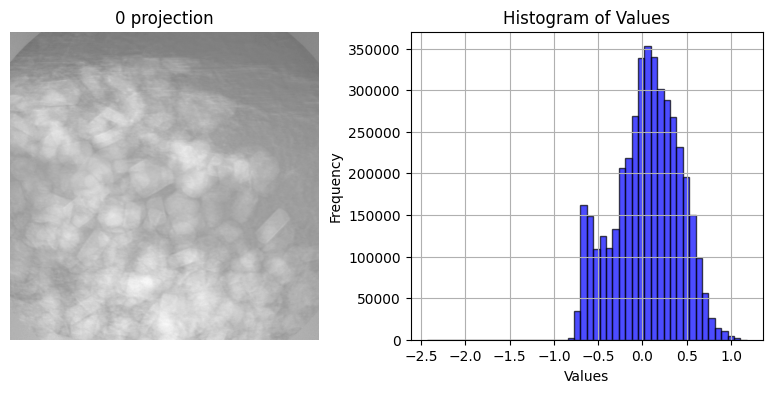

In [39]:
show_image([projections[46]])
projections2 = projections[46]

In [40]:
# average every 10 projections
reshaped_image_data = image_data.reshape(180, 10, 2048, 2048)
projections = reshaped_image_data.mean(axis=1)
projections.shape

(180, 2048, 2048)

In [42]:
(projections[46] - projections2).sum()

-1807.3358

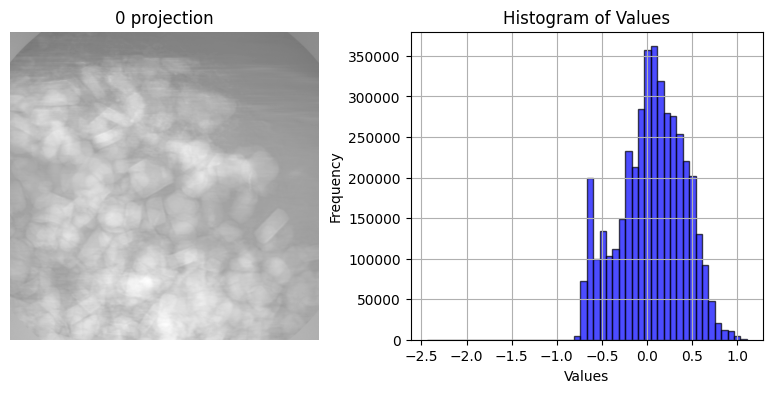

In [41]:
show_image([projections[46]])

Resize images to 256x256 and adjust in predefined range.

In [9]:
resized_projections = []
target_size = (256, 256)
min_thresh = 0.0
max_thresh = 0.07

for i in tqdm(range(projections.shape[0])):

    # Convert each slice to uint8 format (0-255) for resizing
    slice_normalized = ((projections[i] - projections[i].min()) / (projections[i].max() - projections[i].min()) * 255).astype(np.uint8)
    
    # Convert slice to PIL image, resize, and back to numpy array
    resized_slice = Image.fromarray(slice_normalized).resize(target_size, Image.BICUBIC)
    resized_slice = np.array(resized_slice, dtype=np.float32)

    # Rescale to the specified range
    resized_slice = resized_slice / 255.0  # Normalize to 0-1
    resized_slice = resized_slice * (max_thresh - min_thresh) + min_thresh  # Scale to [min_thresh, max_thresh]
    
    resized_projections.append(np.array(resized_slice))

# Stack the resized slices back into a single numpy array
resized_projections = np.stack(resized_projections, axis=0)
resized_projections.shape

  0%|          | 0/180 [00:00<?, ?it/s]

100%|██████████| 180/180 [00:04<00:00, 37.25it/s]


(180, 256, 256)

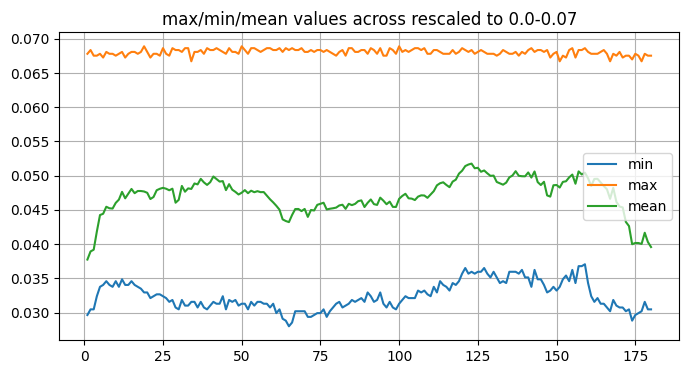

In [10]:
plot_statistics(resized_projections, f'rescaled to {min_thresh}-{max_thresh}')

Here we have two options. We can either save to npz to be able to reconstruct with regular CT (e.g., FDK, SART, OSSART), or save to pickle and pass it to SaxNerf or R2Gaussian and so on

In [11]:
# Acquisition angles
total_angle = 180.0
num_train = 180
start_angle = 0.0
print(f'{num_train} projections selected!')

180 projections selected!


In [12]:
# Generate angles with fixed intervals
angles = np.linspace(0, total_angle / 180 * np.pi, num_train+1)[:-1] + start_angle/ 180 * np.pi
print(angles.shape)

# Pick projections according to angles
start_proj = 0
end_proj = 180

final_projections = resized_projections[start_proj:end_proj]#[::2]
final_projections.shape

(180,)


(180, 256, 256)

In [17]:
# Generate angles with random intervals

# Step 1: Generate `num_train` unique random indices between 0 and 179 (representing angles in degrees)
random_indices = np.random.choice(180, size=num_train, replace=False)  # No duplicates
random_indices.sort()

# Step 2: Select the corresponding projections
final_projections = resized_projections[random_indices]

# Step 3: Convert the selected indices (angles in degrees) to radians
angles = random_indices * (np.pi / 180)

print(f'final_projections: {final_projections.shape}')
print(f'angles: {angles.shape}')

final_projections: (90, 256, 256)
angles: (90,)


In [13]:
angles

array([0.        , 0.01745329, 0.03490659, 0.05235988, 0.06981317,
       0.08726646, 0.10471976, 0.12217305, 0.13962634, 0.15707963,
       0.17453293, 0.19198622, 0.20943951, 0.2268928 , 0.2443461 ,
       0.26179939, 0.27925268, 0.29670597, 0.31415927, 0.33161256,
       0.34906585, 0.36651914, 0.38397244, 0.40142573, 0.41887902,
       0.43633231, 0.45378561, 0.4712389 , 0.48869219, 0.50614548,
       0.52359878, 0.54105207, 0.55850536, 0.57595865, 0.59341195,
       0.61086524, 0.62831853, 0.64577182, 0.66322512, 0.68067841,
       0.6981317 , 0.71558499, 0.73303829, 0.75049158, 0.76794487,
       0.78539816, 0.80285146, 0.82030475, 0.83775804, 0.85521133,
       0.87266463, 0.89011792, 0.90757121, 0.9250245 , 0.9424778 ,
       0.95993109, 0.97738438, 0.99483767, 1.01229097, 1.02974426,
       1.04719755, 1.06465084, 1.08210414, 1.09955743, 1.11701072,
       1.13446401, 1.15191731, 1.1693706 , 1.18682389, 1.20427718,
       1.22173048, 1.23918377, 1.25663706, 1.27409035, 1.29154

In [14]:
print(np.min(final_projections))
print(np.max(final_projections))

0.028
0.06890196


This is the npz saving part.

In [15]:
file_path = "../data/battery/3_clear/npz/projs_angles_50_random_projs.npz"
np.savez(file_path, projs=final_projections, angles=angles)

print(f"NPZ saved in {file_path}.")

NPZ saved in ../data/battery/3_clear/npz/projs_angles_50_random_projs.npz.


This is the npz reading part.

In [47]:
import numpy as np

name_projs_angles = 'projs_angles_70_random_projs'
data = np.load(f'../data/battery/3_clear/npz/range_0_1/{name_projs_angles}.npz')
for key in data.keys():
    print(f"{key}: {data[key].shape}")
print()

print('original data range:')
print(np.min(data['projs']))
print(np.max(data['projs']))
print()

def rescale_array(array, new_min, new_max):
    old_min, old_max = array.min(), array.max()
    return (array - old_min) / (old_max - old_min) * (new_max - new_min) + new_min

resized_projections = rescale_array(data['projs'], new_min=0, new_max=0.07)
print('new data range:')
print(np.min(resized_projections))
print(np.max(resized_projections))

# some plotting
'''
plot_statistics(resized_projections, 'rescaled images')

id_random_proj = np.random.randint(180)
plt.imshow(resized_projections[id_random_proj], cmap="gray")
plt.title(f"{id_random_proj} Projection")
plt.show()
'''

'''
dict_npz = {
    'projs': rescaled_array,
    'angles': data['angles']
}
'''

# saving projs and angles to npz
file_path = f"../data/battery/3_clear/npz/range_0_007/{name_projs_angles}.npz"
np.savez(file_path, projs=resized_projections, angles=data['angles'])

print(f"NPZ saved in {file_path}.")

# storing train data
final_projections = resized_projections
angles = data['angles']

projs: (180, 256, 256)
angles: (70,)

original data range:
0.4
0.9843137

new data range:
0.0
0.07
NPZ saved in ../data/battery/3_clear/npz/range_0_007/projs_angles_70_random_projs.npz.


This is the pickle saving part. In theory you should have the 3D CT volume (precomputed e.g. with SART) and use it as ground truth. You assign such volume to the `image` attribute in the `picke_dict` dictionary.

In [15]:
gt_volume = np.zeros((256, 256, 256))
#gt_volume = np.load("data/npy/no_ghost/SART_1_180.npy")

This is the pickle constructor for SaxNerf

In [16]:
import pickle

pickle_dict = {
    "numTrain": 180,                # my train projections
    "numVal": 180,                  # we test on the same train projections
    "DSD": 1500.0,
    "DSO": 1000.0,
    "nDetector": [256, 256],        # image size
    "dDetector": [1.0, 1.0],        # pixel size
    "nVoxel": [256, 256, 256],
    "dVoxel": [1.0, 1.0, 1.0],    
    "offOrigin": [0, 0, 0],
    "offDetector": [0, 0],
    "accuracy": 0.5,
    "mode": "parallel",
    "filter": None,
    "totalAngle": total_angle,
    "startAngle": start_angle,
    "randomAngle": False,
    "convert": True,
    "rescale_slope": 1.0,
    "rescale_intercept": 0.0,
    "normalize": True,
    "noise": 0,
    "image": gt_volume,                # GT volume, if any
    "train": {
        "angles": angles,
        "projections": final_projections
    },
    "val": {
        "angles": angles,
        "projections": final_projections
    }
}

file_path = "../data/z-bin/180_no_avg_saxnerf.pickle"
with open(file_path, 'wb') as file:
    pickle.dump(pickle_dict, file)

print(f"{file_path} saved!")

../data/z-bin/180_no_avg_saxnerf.pickle saved!


This is the pickle file to be fed to R2Gaussian.

In [15]:
import pickle

pickle_dict = {
    "mode": "parallel",
    "DSD": 1500.0,
    "DSO": 1000.0,
    "nDetector": [256, 256],        # image size
    "sDetector": [256, 256],
    "nVoxel": [256, 256, 256],
    "sVoxel": [256, 256, 256],
    "offOrigin": [0, 0, 0],
    "offDetector": [0, 0],
    "accuracy": 0.5,
    "totalAngle": total_angle,
    "startAngle": start_angle,
    "noise": True,
    "filter": None,
    "numTrain": num_train,                  # my train projections
    "numVal": num_train,                    # we test on the same train projections
    "dDetector": [1.0, 1.0],                # pixel size
    "dVoxel": [1.0, 1.0, 1.0],    
    "train": {
        "angles": angles,
        "projections": final_projections
    },
    "val": {
        "angles": angles,
        "projections": final_projections
    },
    "image": gt_volume,                # GT volume, if any
}

'''
"randomAngle": False,
"convert": True,
"rescale_slope": 1.0,
"rescale_intercept": 0.0,
"normalize": True,
'''

file_path = "../data/z-bin/180_no_avg_3dgs.pickle"
with open(file_path, 'wb') as file:
    pickle.dump(pickle_dict, file)

print(f"{file_path} saved!")

../data/z-bin/180_no_avg_3dgs.pickle saved!


In [43]:
final_projections.shape

(180, 256, 256)